In [1]:
import os 
os.chdir('../../../')
print("Current working directory is now: ", os.getcwd())

import pandas as pd 
import numpy as np
import csv
import utils.interpretable_functions as interpret
import utils.RiskSLIM as slim
import utils.stumps as stumps
import utils.Corel as Corel

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_auc_score

# restore saved variables
%store -r summary_drug2_KY_interpret

Current working directory is now:  C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2


C:\Users\binha\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



### CART & EBM

In [2]:
### load data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_data.csv")
data = data.drop(['fta_risk_score_raw','nca_risk_score_raw','pvf_risk_score_raw', 
                  'fta_calc', 'nca_calc', 'pvf_calc'], axis=1)
x = data.loc[:,:'current_violence']
y = data['recid_drug_six_month'].values

In [4]:
#### CART
depth = [6,7,8]
cart_summary = interpret.CART(X=x,
                         Y=y,
                         depth=depth,
                         seed=816)

#### EBM
estimators = [40]
depth = [2]
learning_rate = [0.5]
ebm_summary = interpret.EBM(X=x,
                       Y=y,
                       learning_rate=learning_rate,
                       depth=depth,
                       estimators=estimators,
                       seed =816)

model_id, score_thresholds 0 {'rank_abs': [2]}
get_disparity_predefined_group()


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars



model_id, score_thresholds 0 {'rank_abs': [7]}
get_disparity_predefined_group()


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars



model_id, score_thresholds 0 {'rank_abs': [10]}
get_disparity_predefined_group()


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars



model_id, score_thresholds 0 {'rank_abs': [7]}
get_disparity_predefined_group()


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars



model_id, score_thresholds 0 {'rank_abs': [2]}
get_disparity_predefined_group()


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars



model_id, score_thresholds 0 {'rank_abs': [1]}
get_disparity_predefined_group()


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars



model_id, score_thresholds 0 {'rank_abs': [2]}
get_disparity_predefined_group()


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars



model_id, score_thresholds 0 {'rank_abs': [0]}
get_disparity_predefined_group()


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars



model_id, score_thresholds 0 {'rank_abs': [1]}
get_disparity_predefined_group()


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars



model_id, score_thresholds 0 {'rank_abs': [1]}
get_disparity_predefined_group()


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars



In [5]:
np.mean(cart_summary['holdout_test_auc']), np.mean(cart_summary['auc_diffs'])

(0.7500327841598888, 0.023742202616642748)

In [6]:
np.mean(ebm_summary['holdout_test_auc']), np.mean(ebm_summary['auc_diffs'])

(0.7568860305620548, 0.016508482212823306)

## Lasso Stumps

In [7]:
## load whole data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_stumps.csv")
X_stumps, Y_stumps = data.loc[:,:'current_violence>=1'], data['recid_drug_six_month'].values
Y_stumps[Y_stumps == -1] = 0
cols = X_stumps.columns[3:]

## load train & test data
train_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_train_stumps.csv")
test_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_test_stumps.csv")
X_train_stumps, Y_train_stumps = train_stumps.loc[:,:'current_violence>=1'], train_stumps['recid_drug_six_month'].values
X_test_stumps, Y_test_stumps = test_stumps.loc[:,:'current_violence>=1'], test_stumps['recid_drug_six_month'].values
Y_train_stumps[Y_train_stumps == -1] = 0
Y_test_stumps[Y_test_stumps == -1] = 0

#### Nested Cross Validation

In [8]:
stump_summary = stumps.stump_cv(X = X_stumps, 
                                Y = Y_stumps, 
                                columns=cols, 
                                c_grid={'C': [0.001, 0.003, 0.005]}, 
                                seed = 816)

model_id, score_thresholds 0 {'rank_abs': [7770]}
get_disparity_predefined_group()


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars



model_id, score_thresholds 0 {'rank_abs': [7698]}
get_disparity_predefined_group()


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars



model_id, score_thresholds 0 {'rank_abs': [8294]}
get_disparity_predefined_group()


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars



model_id, score_thresholds 0 {'rank_abs': [7844]}
get_disparity_predefined_group()


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars



model_id, score_thresholds 0 {'rank_abs': [8535]}
get_disparity_predefined_group()


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars



In [9]:
stump_summary['best_params'], np.mean(stump_summary['holdout_test_auc']), np.mean(stump_summary['auc_diffs'])

([{'C': 0.005}, {'C': 0.005}, {'C': 0.005}, {'C': 0.005}, {'C': 0.005}],
 0.7610841238235442,
 0.003638177215731364)

##### Best Stump Model

In [10]:
best_stump_model = stumps.stump_model(X_train_stumps, 
                                      Y_train_stumps, 
                                      X_test_stumps, 
                                      Y_test_stumps, 
                                      c=0.005, 
                                      columns=cols, 
                                      seed=816)
len(best_stump_model['features'])

25

##### Prediction Table

In [11]:
stumps.latex_stump_table(best_stump_model['coefs'], 
                   best_stump_model['features'], 
                   best_stump_model['intercept'], 
                   best_stump_model['dictionary'])

egin{tabular}{|l|r|r|} \hline
1. age_at_current_charge<=24 & 1.2 & -... \ \hline
2. age_at_current_charge<=29 & 6.2 & -... \ \hline
3. age_at_current_charge<=38 & 1.0 & +... \ \hline
4. p_arrest>=1 & 39.8 & -... \ \hline
5. p_arrest>=2 & 30.4 & +... \ \hline
6. p_arrest>=3 & 16.8 & +... \ \hline
7. p_arrest>=4 & 9.8 & +... \ \hline
8. p_arrest>=5 & 9.0 & +... \ \hline
9. p_arrest>=6 & 7.0 & +... \ \hline
10. p_charges>=1 & 48.7 & -... \ \hline
11. p_charges>=2 & 3.9 & +... \ \hline
12. p_charges>=3 & 1.4 & +... \ \hline
13. p_felony>=1 & 23.0 & +... \ \hline
14. p_felony>=2 & 14.0 & +... \ \hline
15. p_misdemeanor>=1 & 17.9 & +... \ \hline
16. p_misdemeanor>=2 & 11.4 & +... \ \hline
17. p_drug>=1 & 133.9 & +... \ \hline
18. p_drug>=2 & 3.8 & +... \ \hline
19. p_stealing>=1 & 29.0 & -... \ \hline
20. ADE>=1 & 86.2 & -... \ \hline
21. p_prison>=1 & 51.9 & -... \ \hline
22. p_jail30>=1 & 0.5 & +... \ \hline
23. p_pending_charge>=1 & 75.3 & +... \ \hline
24. p_probation>=1 & 13.3 & +... \

##### Stumps Visualizations

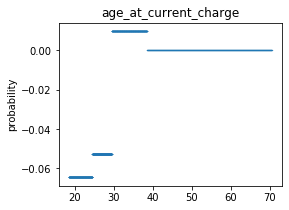

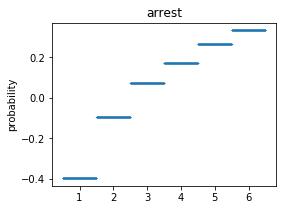

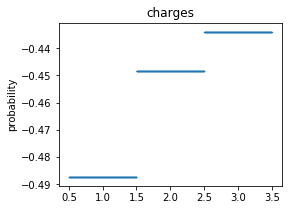

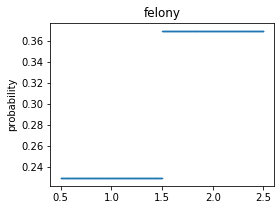

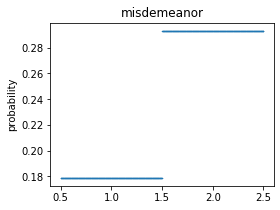

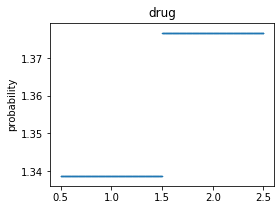

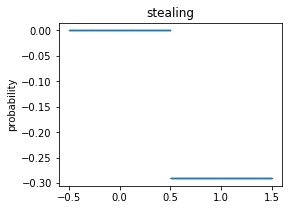

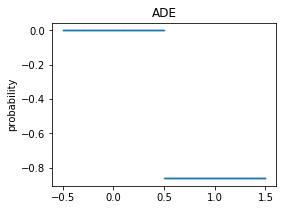

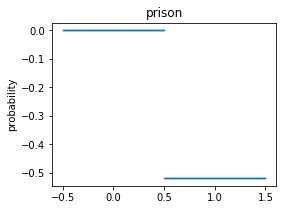

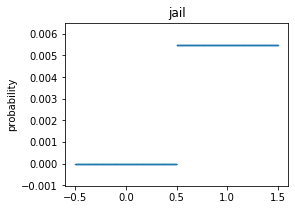

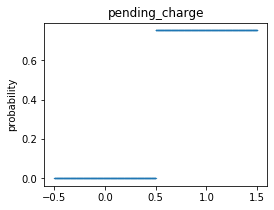

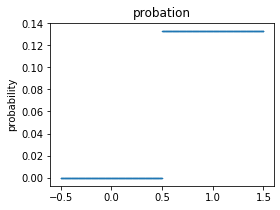

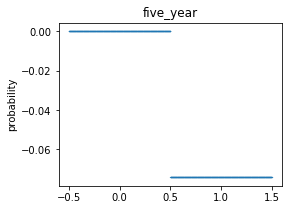

In [12]:
stumps.stump_plots(best_stump_model['features'], best_stump_model['coefs'], indicator='KY')

## RiskSLIM

In [13]:
## load stumps data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_stumps.csv")
x, y = data.loc[:,:'current_violence>=1'], data['recid_drug_six_month'].values
cols = x.columns[3:]

In [14]:
## train on best param chosen by Lasso Stumps from above
x_train = x.copy().drop(['race', 'person_id', 'screening_date'], axis=1)
lasso = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=0.005, random_state=816).fit(x_train,y)
selected_features = cols[lasso.coef_[0] != 0].tolist()
len(selected_features)

26

In [15]:
### Subset features
if 'sex>=1' in selected_features:
    selected_features = ['recid_drug_six_month', 'person_id', 'screening_date', 'race'] + selected_features
    indicator = 1
else:
    selected_features = ['recid_drug_six_month', 'person_id', 'screening_date', 'race', 'sex>=1'] + selected_features
    indicator = 0

sub_data = data[selected_features]
sub_X, sub_Y = sub_data.iloc[:,1:], sub_data.iloc[:,0].values
sub_X.insert(0, '(Intercept)', 1)

In [16]:
riskslim_summary = slim.risk_cv(X=sub_X, 
                                Y=sub_Y, 
                                indicator = indicator,
                                y_label='recid_drug6', 
                                max_coef=20, 
                                max_coef_number=10, 
                                max_runtime=200, 
                                c=1e-6, 
                                seed=816)

setting c0 = 0.0 to ensure that intercept is not penalized
10/01/19 @ 04:57 PM | 1141 rows in lookup table
10/01/19 @ 04:57 PM | ------------------------------------------------------------
10/01/19 @ 04:57 PM | runnning initialization procedure
10/01/19 @ 04:57 PM | ------------------------------------------------------------
10/01/19 @ 04:57 PM | CPA produced 2 cuts
10/01/19 @ 04:57 PM | running naive rounding on 86 solutions
10/01/19 @ 04:57 PM | best objective value: 0.1138
10/01/19 @ 04:57 PM | rounding produced 5 integer solutions
10/01/19 @ 04:57 PM | best objective value is 0.1146
10/01/19 @ 04:57 PM | running sequential rounding on 86 solutions
10/01/19 @ 04:57 PM | best objective value: 0.1138
10/01/19 @ 04:57 PM | sequential rounding produced 4 integer solutions
10/01/19 @ 04:57 PM | best objective value: 0.1146
10/01/19 @ 04:57 PM | polishing 9 solutions
10/01/19 @ 04:57 PM | best objective value: 0.1146
10/01/19 @ 04:57 PM | polishing produced 4 integer solutions
10/01/19 

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/01/19 @ 04:57 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.1146.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 56 columns, and 107 nonzeros.
Reduced MIP has 26 binaries, 28 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.06 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variab

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars



setting c0 = 0.0 to ensure that intercept is not penalized
10/01/19 @ 04:59 PM | 1141 rows in lookup table
10/01/19 @ 04:59 PM | ------------------------------------------------------------
10/01/19 @ 04:59 PM | runnning initialization procedure
10/01/19 @ 04:59 PM | ------------------------------------------------------------
10/01/19 @ 05:00 PM | CPA produced 2 cuts
10/01/19 @ 05:00 PM | running naive rounding on 96 solutions
10/01/19 @ 05:00 PM | best objective value: 0.1136
10/01/19 @ 05:00 PM | rounding produced 5 integer solutions
10/01/19 @ 05:00 PM | best objective value is 0.1163
10/01/19 @ 05:00 PM | running sequential rounding on 96 solutions
10/01/19 @ 05:00 PM | best objective value: 0.1136
10/01/19 @ 05:00 PM | sequential rounding produced 4 integer solutions
10/01/19 @ 05:00 PM | best objective value: 0.1148
10/01/19 @ 05:00 PM | polishing 9 solutions
10/01/19 @ 05:00 PM | best objective value: 0.1148
10/01/19 @ 05:00 PM | polishing produced 5 integer solutions
10/01/19 

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/01/19 @ 05:00 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.1148.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 56 columns, and 107 nonzeros.
Reduced MIP has 26 binaries, 28 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.06 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variab

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars



setting c0 = 0.0 to ensure that intercept is not penalized
10/01/19 @ 05:03 PM | 1141 rows in lookup table
10/01/19 @ 05:03 PM | ------------------------------------------------------------
10/01/19 @ 05:03 PM | runnning initialization procedure
10/01/19 @ 05:03 PM | ------------------------------------------------------------
10/01/19 @ 05:03 PM | CPA produced 2 cuts
10/01/19 @ 05:03 PM | running naive rounding on 90 solutions
10/01/19 @ 05:03 PM | best objective value: 0.1134
10/01/19 @ 05:03 PM | rounding produced 4 integer solutions
10/01/19 @ 05:03 PM | best objective value is 0.1142
10/01/19 @ 05:03 PM | running sequential rounding on 90 solutions
10/01/19 @ 05:03 PM | best objective value: 0.1134
10/01/19 @ 05:03 PM | sequential rounding produced 4 integer solutions
10/01/19 @ 05:03 PM | best objective value: 0.1142
10/01/19 @ 05:03 PM | polishing 8 solutions
10/01/19 @ 05:03 PM | best objective value: 0.1142
10/01/19 @ 05:03 PM | polishing produced 5 integer solutions
10/01/19 

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/01/19 @ 05:03 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.1142.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 56 columns, and 107 nonzeros.
Reduced MIP has 26 binaries, 28 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.06 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variab

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars



setting c0 = 0.0 to ensure that intercept is not penalized
10/01/19 @ 05:05 PM | 1141 rows in lookup table
10/01/19 @ 05:05 PM | ------------------------------------------------------------
10/01/19 @ 05:05 PM | runnning initialization procedure
10/01/19 @ 05:05 PM | ------------------------------------------------------------
10/01/19 @ 05:05 PM | CPA produced 2 cuts
10/01/19 @ 05:05 PM | running naive rounding on 90 solutions
10/01/19 @ 05:05 PM | best objective value: 0.1124
10/01/19 @ 05:05 PM | rounding produced 4 integer solutions
10/01/19 @ 05:05 PM | best objective value is 0.1135
10/01/19 @ 05:05 PM | running sequential rounding on 90 solutions
10/01/19 @ 05:05 PM | best objective value: 0.1124
10/01/19 @ 05:05 PM | sequential rounding produced 4 integer solutions
10/01/19 @ 05:05 PM | best objective value: 0.1135
10/01/19 @ 05:05 PM | polishing 8 solutions
10/01/19 @ 05:05 PM | best objective value: 0.1135
10/01/19 @ 05:05 PM | polishing produced 5 integer solutions
10/01/19 

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/01/19 @ 05:05 PM | adding 242 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.1135.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 56 columns, and 107 nonzeros.
Reduced MIP has 26 binaries, 28 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.06 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variab

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars



setting c0 = 0.0 to ensure that intercept is not penalized
10/01/19 @ 05:08 PM | 1141 rows in lookup table
10/01/19 @ 05:08 PM | ------------------------------------------------------------
10/01/19 @ 05:08 PM | runnning initialization procedure
10/01/19 @ 05:08 PM | ------------------------------------------------------------
10/01/19 @ 05:08 PM | CPA produced 2 cuts
10/01/19 @ 05:08 PM | running naive rounding on 88 solutions
10/01/19 @ 05:08 PM | best objective value: 0.1138
10/01/19 @ 05:08 PM | rounding produced 3 integer solutions
10/01/19 @ 05:08 PM | best objective value is 0.1149
10/01/19 @ 05:08 PM | running sequential rounding on 88 solutions
10/01/19 @ 05:08 PM | best objective value: 0.1138
10/01/19 @ 05:08 PM | sequential rounding produced 4 integer solutions
10/01/19 @ 05:08 PM | best objective value: 0.1149
10/01/19 @ 05:08 PM | polishing 7 solutions
10/01/19 @ 05:08 PM | best objective value: 0.1149
10/01/19 @ 05:08 PM | polishing produced 5 integer solutions
10/01/19 

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/01/19 @ 05:08 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.1149.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 56 columns, and 107 nonzeros.
Reduced MIP has 26 binaries, 28 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.06 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variab

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars



In [17]:
np.mean(riskslim_summary['train_auc']), np.mean(riskslim_summary['test_auc'])

(0.7286364971390991, 0.7286166294953176)

### Arnold PSA

In [18]:
### load data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_data.csv")
X_arnold = data['nca_risk_score_raw'].values
Y_arnold = data['recid_drug_six_month'].values

## set up cross validation
cv = KFold(n_splits=5,shuffle=True,random_state=816)
arnold_auc = []
for train, test in cv.split(X_arnold, Y_arnold):
    y_pred_arnold, y_test = X_arnold[test], Y_arnold[test]
    arnold_auc.append(roc_auc_score(y_test, y_pred_arnold))

### Corel

In [2]:
## load stumps data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_stumps.csv")
x, y = data.loc[:,:'current_violence>=1'], data['recid_drug_six_month'].values
y[y == -1] = 0

In [3]:
corel_summary = Corel.corel_cv(x, y, max_card=2, c=1e-4, seed=816)

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha

In [4]:
np.mean(corel_summary['test_auc']), np.std(corel_summary['test_auc'])

(0.5, 0.0)

### Results

In [22]:
#### save results
summary_drug6_KY_interpret = {"CART": cart_summary,
                              "EBM": ebm_summary, 
                              'Lasso Stumps': stump_summary, 
                              'RiskSLIM': riskslim_summary,  
                              'Corel': corel_summary,
                              'Arnold PSA': arnold_auc}
%store summary_drug6_KY_interpret

Stored 'summary_drug6_KY_interpret' (dict)


In [23]:
results = [["CART", np.mean(cart_summary['holdout_test_auc']), np.mean(cart_summary['auc_diffs'])],
           ["EBM", np.mean(ebm_summary['holdout_test_auc']), np.mean(ebm_summary['auc_diffs'])], 
           ["Lasso Stumps", np.mean(stump_summary['holdout_test_auc']), np.mean(stump_summary['auc_diffs'])],
           ['RiskSLIM', np.mean(riskslim_summary['test_auc'])],
           ['Corel', np.mean(corel_summary['test_auc'])],
           ['Arnold PSA', round(np.mean(arnold_auc), 3)]]
results

[['CART', 0.7500327841598888, 0.023742202616642748],
 ['EBM', 0.7568860305620548, 0.016508482212823306],
 ['Lasso Stumps', 0.7610841238235442, 0.003638177215731364],
 ['RiskSLIM', 0.7286166294953176],
 ['Corel', 0.5],
 ['Arnold PSA', 0.652]]

In [24]:
auc = [np.mean(cart_summary['holdout_test_auc']), 
       np.mean(ebm_summary['holdout_test_auc']), 
       np.mean(stump_summary['holdout_test_auc']), 
       np.mean(riskslim_summary['test_auc']), 
       np.mean(corel_summary['test_auc'])]

In [25]:
path = "C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY Results/Models/Six Month/"
results = [["Drug", np.str((round(np.mean(cart_summary['holdout_test_auc']), 3))) + " (" + np.str(round(np.std(cart_summary['holdout_test_auc']), 3)) + ")", 
            np.str(round(np.mean(ebm_summary['holdout_test_auc']),3)) + " (" + np.str(round(np.std(ebm_summary['holdout_test_auc']), 3)) + ")", 
            np.str(round(np.mean(stump_summary['holdout_test_auc']),3)) + " (" + np.str(round(np.std(stump_summary['holdout_test_auc']), 3)) + ")",             
            np.str(round(np.mean(riskslim_summary['test_auc']),3)) + " (" + np.str(round(np.std(riskslim_summary['test_auc']), 3)) + ")", 
            np.str(round(np.mean(corel_summary['test_auc']),3)) + " (" + np.str(round(np.std(corel_summary['test_auc']), 3)) + ")", 
            round(np.max(auc) - np.min(auc), 3),
            np.str(round(np.mean(arnold_auc), 3)) + " (" + np.str(round(np.std(arnold_auc),3)) + ")"]]
with open(path + 'Interpretable Models Summary.csv', 'a') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(results)

In [26]:
cart_confusion = cart_summary['confusion_matrix_stats']
ebm_confusion = ebm_summary['confusion_matrix_stats']
riskslim_confusion = riskslim_summary['confusion_matrix_stats']
stumps_confusion = stump_summary['confusion_matrix_stats']
corel_confusion = corel_summary['confusion_matrix_stats']
#arnold_confusion = cart_summary['confusion_matrix_stats']

## save results
cart_confusion.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY Fairness/Six Month/drug/cart_confusion.csv', index=None,header=True)
ebm_confusion.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY Fairness/Six Month/drug/ebm_confusion.csv', index=None,header=True)
riskslim_confusion.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY Fairness/Six Month/drug/riskslim_confusion.csv', index=None,header=True)
stumps_confusion.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY Fairness/Six Month/drug/stumps_confusion.csv', index=None,header=True)
corel_confusion.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY Fairness/Six Month/drug/corel_confusion.csv', index=None,header=True)
#arnold_confusion.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/broward models/model fairness/Two Year/general/arnold_confusion.csv', index=None,header=True)

In [5]:
corel_confusion = corel_summary['confusion_matrix_stats']
corel_confusion.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY Fairness/Six Month/drug/corel_confusion.csv', index=None,header=True)